# Deep learning for tabular data

There's no shortage of hype surrounding deep learning these days. And for good reason. Advances in AI are crossing frontiers that many didn't expect to see crossed for decades with the advent of new algorithms and the hardware that makes training these models feasible.

Most of the discussion surrounding deep learning retains a focus on artificial intelligence, such as NLP and computer vision where the model inputs are images or free text. This is in contrast to many of the problems in industry where the data at hand follows the more tradditional "tabular" structure. This tabular structure is characterized by the following traits

- The data set is 2-dimmensional, i.e. rows and columns.
- The dimmensionality of the feature space (the columns) is fixed.
- The features are made up of mixed types including numeric and categorical values.
- The scales of the numeric values differ from feature to feature.

In this post we will explore how to apply deep learning to the sort of tabular data that many of us work with on a day to day basis. Some of the concepts we'll take a look at in particular include

- Handling categorical features (of varying dimmensionality)
- Augmenting a tabular data set with non-tabular features (such as text, image, etc.)
- Augmenting a tabular data set with features of variable dimmensionality (such as time series, free text, video, etc.)

# The data

In this post we'll work with the [california housing data set](https://scikit-learn.org/stable/datasets/index.html#california-housing-dataset). The base data set that you can import from `sklearn` only contains numeric features. For the purpose of this post I enriched the base data set with zip codes, counties and free text scraped from the wikipedia article of each county. The data was encriched with [this notebook](https://github.com/dantegates/deep-learning-for-tabular-data/blob/master/enrich-california-housing-data.ipynb).

Before getting started I want to point at that this post is meant to be illustrative. The data set is rather small and limits how "deep" out models can be. I also don't claim that the modeling approaches in this notebook are the optimal way to solve this problem, but hopefully demonstrate some principles that can be generalized to other problems.

# The data in detail

Let's take a look at the data set in detail. Here are the first few records.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('california_housing_enriched.csv.gz')
df.shape

(20374, 15)

In [3]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value,zip_code,county,county_description,is_train,zip_code_encoding,county_encoding
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,94611,Contra Costa County,Contra Costa County is a county in the state o...,False,0,1
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,94611,Alameda County,Alameda County (/ˌæləˈmiːdə/ AL-ə-MEE-də) is a...,True,0,0
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,94618,Alameda County,Alameda County (/ˌæləˈmiːdə/ AL-ə-MEE-də) is a...,True,1,0
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,94618,Alameda County,Alameda County (/ˌæləˈmiːdə/ AL-ə-MEE-də) is a...,True,1,0
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,94618,Alameda County,Alameda County (/ˌæləˈmiːdə/ AL-ə-MEE-də) is a...,True,1,0


As we can see there are a mix of numeric and categorical features in the data set as well as the free text scraped from wikipedia that we mentioned above. The target variable is `median_house_value`.

Lastly we'll define our feature columns according to their types for convenience below when we train the models and separate our data into train/test splits.

In [4]:
target = 'median_house_value'
numeric_features = [
    'MedInc',
    'HouseAge',
    'AveRooms',
    'AveBedrms',
    'Population',
    'AveOccup',
    'Latitude',
    'Longitude'
]
categorical_features = [
    'zip_code_encoding',
    'county_encoding',
]
text_features = [
    'county_description'
]
all_features = numeric_features + categorical_features + text_features

In [5]:
X_train = df.loc[df.is_train, all_features]
y_train = df.loc[df.is_train, target]
X_test = df.loc[~df.is_train, all_features]
y_test = df.loc[~df.is_train, target]
X_train.shape, X_test.shape

((16261, 11), (4113, 11))

# Model 1: Basic Feed Forward Network

We'll start simple with a basic feed forward network. We'll simply train the model on all of the numeric features and establish a baseline performance. This is pretty easy with the `keras.Sequential` API. Since we don't have much data we'll only use two hidden layers and keep the number of their outputs small.

Note that the first layer is batch normalization. Before the first layer we can think of this as analagous to using something like `sklearn`'s [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). However in general batch normalization can regularize neural networks and help them converge faster. For this reason we'll use batch normalization between the hidden layers as well. For our small data set this might not be as important but, again, this is meant to be illustrative.

In [6]:
import keras

# numeric features
model = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=(len(numeric_features),)),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='relu'),
])

Using TensorFlow backend.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                180       
_________________________________________________________________
batch_normalization_2 (Batch (None, 20)                80        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
batch_normalization_3 (Batch (None, 20)                80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 813
Trainable params: 717
Non-trainable params: 96
_________________________________________________________________


In [8]:
model.compile(loss='mse', optimizer='adam')

In [9]:
model.fit(
    X_train[numeric_features], y_train,
    epochs=3,
    validation_data=(X_test[numeric_features], y_test)
)

Train on 16261 samples, validate on 4113 samples
Epoch 1/3
16261/16261 [==============================] - 2s 112us/step - loss: 1.4512 - val_loss: 0.7095
Epoch 2/3
16261/16261 [==============================] - 1s 69us/step - loss: 0.5977 - val_loss: 0.5780
Epoch 3/3
16261/16261 [==============================] - 1s 67us/step - loss: 0.5226 - val_loss: 0.5210


After three epochs MSE is at 0.52, which isn't great and the model may be close to overfitting a bit, but it's a start. Let's take a look at a plot of the actual vs. predicted values just to visualize what that MSE means
accross all the entire test set.

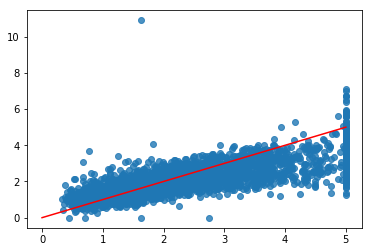

In [10]:
import matplotlib.pyplot as plt
plt.scatter(y_test, model.predict(X_test[numeric_features]), alpha=0.8)
plt.plot([0, 5], [0, 5], color='r')

The performance isn't great, but for a quick and basic implementation perhaps not all that bad either. Let's move on to including categorical features.

# Model 2: Basic Feed Forward Network with Embeddings

In our second approach we'll include zip code and county as features. Let's take a look at the cardinality of these features.

In [11]:
df.zip_code.nunique(), df.county.nunique()

(1725, 61)

There aren't too many counties. If we wanted we could one-hot encode these and include it as a feature that way. However, zip code is much bigger. One hot encoding this feature would significantly increase the size of our network (the first layer will have at least $1,725\times h_1$ weights, where $h_1$ is the number of outputs in the first hidden layer). It turns out that categorical features like this can be represented with embeddings to keep the size of our model down. An embedding is simply a *learned* mapping from a categorical input to a feature space of a chosen size. Typically these are used to convert words or characters in text data into features suitable for a neural network but they work for our purposes here as well. In this case we'll embed both zip codes and counties into 3 dimmensions. Note that there are [pretrained word embeddings](https://radimrehurek.com/gensim/models/word2vec.html) available that can be used instead of learning embeddings as part of your model if desired.

The code to do this in `keras` gives the appearance that more is going on than there actually is. All we are doing here is adding 6 additional features (3 for both categorical values) to the numeric input and then building a basic feed forward neural network on top of that just as we did above. The graphical representation below is helpful.

In [12]:
# numeric features
numeric_inputs = keras.layers.Input(shape=(len(numeric_features),), name='numeric_input')
## normalize the numeric inputs!
x_numeric = keras.layers.BatchNormalization()(numeric_inputs)

# categorical feature embeddings
zip_code_input = keras.layers.Input(shape=(1,), name='zip_code_input')
zip_code_embedding = keras.layers.Embedding(
    input_dim=X_train.zip_code_encoding.nunique()+1,
    output_dim=3, input_length=1)(zip_code_input)

county_input = keras.layers.Input(shape=(1,), name='county_input')
county_embedding = keras.layers.Embedding(
    input_dim=X_train.zip_code_encoding.nunique()+1,
    output_dim=3, input_length=1)(county_input)
embedding_tensors = [zip_code_embedding, county_embedding]
x_embeddings = keras.layers.Concatenate()([keras.layers.Flatten()(embedding) for embedding in embedding_tensors])

x = keras.layers.Concatenate()([x_numeric, x_embeddings])
x = keras.layers.Dense(26, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(14, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='relu')(x)

model = keras.models.Model(inputs=[numeric_inputs, zip_code_input, county_input], outputs=x)

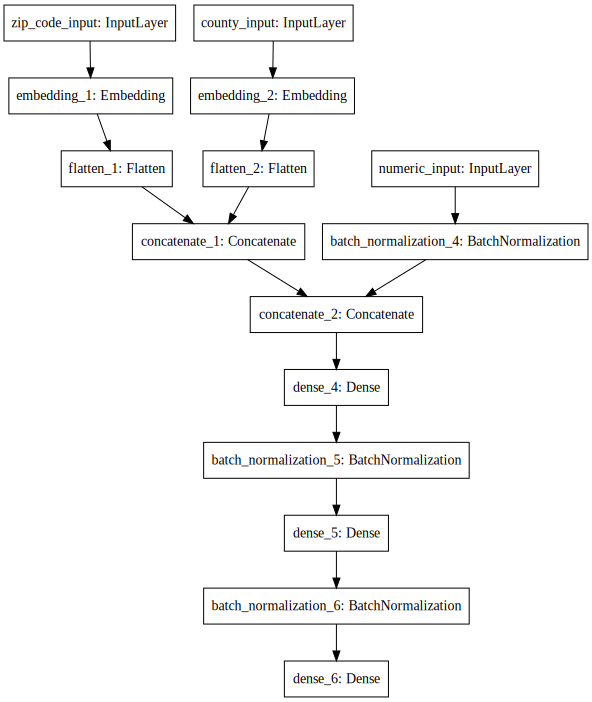

In [13]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [14]:
X_train_input = {
    'numeric_input': X_train[numeric_features],
    'zip_code_input': X_train['zip_code_encoding'],
    'county_input': X_train['county_encoding']
}
X_test_input = {
    'numeric_input': X_test[numeric_features],
    'zip_code_input': X_test['zip_code_encoding'],
    'county_input': X_test['county_encoding']
}

In [15]:
model.compile(loss='mse', optimizer='adam')

In [16]:
model.fit(
    X_train_input, y_train,
    epochs=5,
    validation_data=(X_test_input, y_test)
)

Train on 16261 samples, validate on 4113 samples
Epoch 1/5
16261/16261 [==============================] - 2s 138us/step - loss: 1.5041 - val_loss: 0.4972
Epoch 2/5
16261/16261 [==============================] - 1s 78us/step - loss: 0.5685 - val_loss: 0.3993
Epoch 3/5
16261/16261 [==============================] - 1s 75us/step - loss: 0.4438 - val_loss: 0.3282
Epoch 4/5
16261/16261 [==============================] - 1s 76us/step - loss: 0.3583 - val_loss: 0.2920
Epoch 5/5
16261/16261 [==============================] - 1s 74us/step - loss: 0.2900 - val_loss: 0.2852


Not bad. 5 epochs later and we are already outperforming our first model and aren't overfitting any more (although we didn't try that hard not to overfit the first time).

# Model 3: Including Free Text

In the final model we'll build in this post we'll demonstrate how to include free text as a feature alongside the numeric and embedding features we used above.

The key idea here is to include a component in our model that takes a sequence of variable length (in this case an LSTM) and projects that sequence into a feature space with fixed dimmension. Then we'll concatenate this feature representation alongside the numeric features just as we did with the embeddings above. Note that this approach could also work for other non-tabular data sources such as image or video or time series.

Note that to keep the implementation in this post simple we're actually going to restrict the wikipedia descriptions to 250 characters, and if the description has fewer characters we will just pad the sequence to get the full 250. This has the effect of treating the free text data as having a fixed, and not variable, length as promised. However the code below can be easily adjusted to accomodate this by using a batch generator and padding the batches rather than the entire data set once. Again the graphical representation of the model below is helpful.

Out of curiosity we'll get a rough count of about how many words are in each wiki page.

In [17]:
df.county_description.str.split(' ').apply(len).describe()

count    20374.000000
mean      3434.626141
std       1837.569671
min         47.000000
25%       2299.000000
50%       3341.000000
75%       3508.000000
max       7845.000000
Name: county_description, dtype: float64

In [18]:
tokenizer = keras.preprocessing.text.Tokenizer(num_words=2000)
tokenizer.fit_on_texts(X_test.county_description)

In [19]:
%%time
X_train_descr = [
    s[:250]
    for s in tokenizer.texts_to_sequences(X_train.county_description)]
X_test_descr = [
    s[:250]
    for s in tokenizer.texts_to_sequences(X_test.county_description)]

CPU times: user 1min 14s, sys: 1.02 s, total: 1min 15s
Wall time: 1min 16s


In [20]:
# numeric features
numeric_inputs = keras.layers.Input(shape=(len(numeric_features),), name='numeric_input')
x_numeric = keras.layers.BatchNormalization()(numeric_inputs)


# categorical feature embeddings
zip_code_input = keras.layers.Input(shape=(1,), name='zip_code_input')
zip_code_embedding = keras.layers.Embedding(
    input_dim=X_train.zip_code_encoding.nunique()+1,
    output_dim=3, input_length=1)(zip_code_input)

county_input = keras.layers.Input(shape=(1,), name='county_input')
county_embedding = keras.layers.Embedding(
    input_dim=X_train.zip_code_encoding.nunique()+1,
    output_dim=3, input_length=1)(county_input)
embedding_tensors = [zip_code_embedding, county_embedding]
x_embeddings = keras.layers.Concatenate()([
    keras.layers.Flatten()(embedding) for embedding in embedding_tensors
])


# LSTM input
description_input = keras.layers.Input(shape=(None,), name='descr_input')
description_embedding = keras.layers.Embedding(
    input_dim=2000, output_dim=10, input_length=250)(description_input)
lstm = keras.layers.LSTM(10)(description_embedding)


x = keras.layers.Concatenate()([x_numeric, x_embeddings, lstm])
x = keras.layers.Dense(26, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(14, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='relu')(x)

model = keras.models.Model(
    inputs=[numeric_inputs, zip_code_input, county_input, description_input],
    outputs=x)

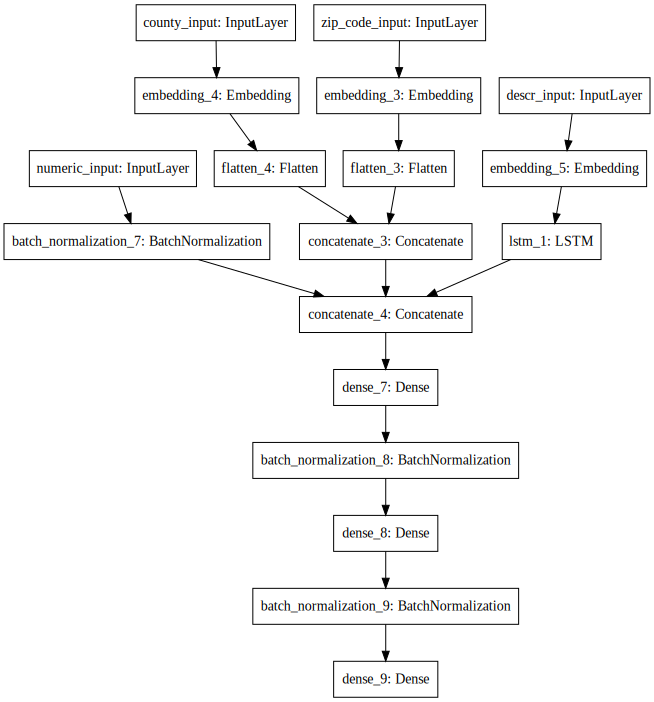

In [21]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [22]:
import numpy as np
X_train_input = {
    'numeric_input': X_train[numeric_features],
    'zip_code_input': X_train['zip_code_encoding'],
    'county_input': X_train['county_encoding'],
    'descr_input': keras.preprocessing.sequence.pad_sequences(X_train_descr, maxlen=250)
}
X_test_input = {
    'numeric_input': X_test[numeric_features],
    'zip_code_input': X_test['zip_code_encoding'],
    'county_input': X_test['county_encoding'],
    'descr_input': keras.preprocessing.sequence.pad_sequences(X_test_descr, maxlen=250)
}

In [23]:
model.compile(loss='mse', optimizer='adam')

In [24]:
model.fit(
    X_train_input, y_train,
    epochs=5,
    validation_data=(X_test_input, y_test)
)

Train on 16261 samples, validate on 4113 samples
Epoch 1/5
16261/16261 [==============================] - 103s 6ms/step - loss: 1.2729 - val_loss: 0.5273
Epoch 2/5
16261/16261 [==============================] - 101s 6ms/step - loss: 0.5273 - val_loss: 0.3623
Epoch 3/5
16261/16261 [==============================] - 101s 6ms/step - loss: 0.3856 - val_loss: 0.3293
Epoch 4/5
16261/16261 [==============================] - 101s 6ms/step - loss: 0.3456 - val_loss: 0.2808
Epoch 5/5
16261/16261 [==============================] - 102s 6ms/step - loss: 0.3030 - val_loss: 0.2687


We see that including the text data improves the model's error after training for 5 epochs. However, this likely means that these features are simply helping the model *converge* faster not *perform* better since there is a 1-1 relationship with county description and county (which is to day the free text isn't actually adding information not already encoded in the county, instead including information about that counties that helps the model learn how to generalize from county to county faster). I imagine that if this model and the previous model were both trained longer they would achieve very similar performance after converging. The real advantage performance-wise of this sort of technique would be if each training example had it's own unique description - something like [this dataset](https://www.kaggle.com/c/mercari-price-suggestion-challenge).

# Conclusion

These are just a few ideas to get you started with using deep learning techniques with tabular data. Some of these techniques could even be used to generate features for other algorithms (like using pretrained embeddings as input to a decision tree), however I like to keep everything in `keras`. The possibilities, of course, are endless, but hopefully this post gives you an idea where to start.